# Predict Open Market price using overnight Bitcoin price 

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import datetime
import datetime as dt

from sklearn.svm import SVR
from sklearn import svm
from sklearn.model_selection import train_test_split

/Users/guapofish/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/Users/guapofish/opt/anaconda3/lib/python3.7/site-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



In [2]:
df = pd.read_csv("/Users/guapofish/Desktop/huobi_btcusdt_1min.csv")
df = df.drop(columns=[df.columns[0]]).dropna()
dff = df.set_index('date')

In [3]:
dff.head()

,symbol,open,high,low,close,count,vol,amount
date,,,,,,,,
2018/5/10 0:00,btcusdt,9285.92,9294.47,9281.98,9293.54,133.0,7.331035,68086.40497
2018/5/10 0:01,btcusdt,9294.47,9294.47,9288.05,9289.83,141.0,6.224018,57825.28359
2018/5/10 0:02,btcusdt,9289.83,9291.66,9289.81,9290.00,118.0,8.208307,76260.16626
2018/5/10 0:03,btcusdt,9289.83,9290.00,9287.93,9289.07,97.0,7.356649,68341.46599
2018/5/10 0:04,btcusdt,9289.07,9290.28,9288.43,9290.28,86.0,12.011540,111585.06220


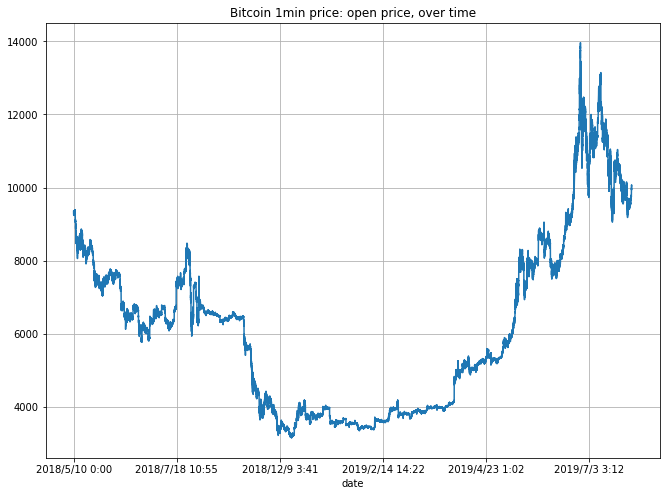

In [4]:
ax = dff['open'].plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("Bitcoin 1min price: open price, over time")
#df.reset_index()

In [5]:
#download stock data UPRO from 2018.05.10 - 2019.07.31
pd.core.common.is_list_like = pd.api.types.is_list_like

symbol=['UPRO']
stocks = symbol
start = datetime.datetime(2018,5,10)
end = datetime.datetime(2019,7,31)
f = pdr.get_data_yahoo(stocks, start=start, end=end)
f_return = f[['Adj Close','Open']]
f_return.columns = f_return.columns.droplevel(1)
f_return



Attributes,Adj Close,Open
Date,,
2018-05-10,46.625538,46.320000
2018-05-11,46.888863,47.290001
2018-05-14,47.089653,47.866665
2018-05-15,46.082424,46.959999
2018-05-16,46.668320,46.680000
...,...,...
2019-07-25,57.538521,58.369999
2019-07-26,58.713997,58.230000
2019-07-29,58.415146,58.849998


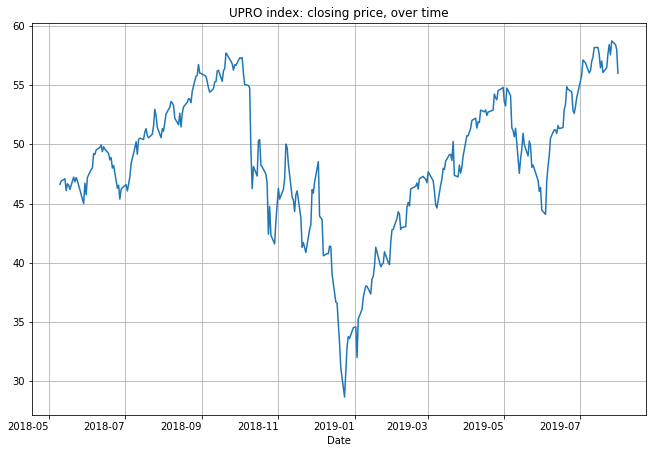

In [6]:
ax = f_return['Adj Close'].plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("UPRO index: closing price, over time")

In [7]:
#Change the datetime formatting for later merging with Bitcoin's Date
f_return = f_return.reset_index()
f_return.Date = f_return.Date.dt.strftime('%Y/%m/%d')

#Calculate the after hour return by shift the closed price from the previous day
f_return['Adj Close'] = f_return['Adj Close'].shift(1)
f_return["overnight_ret"] = f_return['Open']/f_return['Adj Close'] - 1
f_return

Attributes,Date,Adj Close,Open,overnight_ret
0,2018/05/10,NaN,46.320000,NaN
1,2018/05/11,46.625538,47.290001,0.014251
2,2018/05/14,46.888863,47.866665,0.020854
3,2018/05/15,47.089653,46.959999,-0.002753
4,2018/05/16,46.082424,46.680000,0.012968
...,...,...,...,...
303,2019/07/25,58.405190,58.369999,-0.000603
304,2019/07/26,57.538521,58.230000,0.012018
305,2019/07/29,58.713997,58.849998,0.002316
306,2019/07/30,58.415146,57.689999,-0.012414


In [8]:
# extract price of bitcoin only from market open and market close
def output_df(df):
    
    def extract_hour(x):
        splited = x.split(" ")
        if splited[1] == '9:00' or splited[1] == '18:00':
            return True
        else:
            return False

    df['bool'] = df['date'] #Copy a 'bool' from 'date'
    df['bool'] = df['bool'].apply(lambda x: extract_hour(x))
    df = df[df['bool'] == True] 
    df = df.drop(columns='bool') 
    df = df.iloc[1:-1]
    
    return df


In [9]:
df1 = output_df(df)
df1['date'] = df1['date'].apply(lambda x: x.split(' ')[0])
df1['date'] = pd.to_datetime(df1['date']).dt.strftime('%Y/%m/%d')
df1


,symbol,date,open,high,low,close,count,vol,amount
1080,btcusdt,2018/05/10,9354.05,9354.66,9352.36,9352.41,63.0,6.227700,58250.461980
1980,btcusdt,2018/05/11,8945.00,8953.49,8945.00,8953.49,202.0,31.422932,281220.359300
2520,btcusdt,2018/05/11,8723.85,8768.05,8721.71,8768.05,245.0,20.825473,182128.632700
3420,btcusdt,2018/05/12,8460.39,8461.06,8446.40,8449.15,60.0,4.478000,37875.335120
3960,btcusdt,2018/05/12,8503.54,8510.00,8477.48,8509.51,384.0,31.237300,265422.776800
...,...,...,...,...,...,...,...,...,...
639544,btcusdt,2019/07/29,9534.59,9535.49,9533.57,9534.00,59.0,0.932288,8889.336057
640084,btcusdt,2019/07/29,9499.63,9502.00,9497.76,9500.84,143.0,14.893558,141496.554900
640984,btcusdt,2019/07/30,9531.77,9532.29,9531.15,9531.16,70.0,5.841868,55680.123780
641524,btcusdt,2019/07/30,9484.99,9487.46,9484.94,9487.46,80.0,4.126349,39141.079260


In [10]:
A = set(df1.date.unique())
B = set(f_return.Date.unique())
print(len(A),len(B))
print("The intersection of the two table is length: " +str(len(B.intersection(A))))


369 308
The intersection of the two table is length: 256


In [11]:
merged = f_return.merge(df1, left_on='Date', right_on='date', how='inner')
print(len(merged.Date.unique()),len(merged.date.unique()))
print("The length of the joint table is as expected")


256 256
The length of the joint table is as expected


In [12]:
print(merged['Date'].value_counts().head(10))
# detect duplicate date 
merged[189:]
#from line 190 - 193, there exptected to have only two date in a row, but it happens on Date 2018/12/10 
#Same to the other days from the top counts, we need to remove the duplicate 

2019/03/18    4
2019/01/09    4
2019/05/01    4
2019/04/03    4
2019/07/11    4
2018/12/10    4
2019/03/06    2
2019/05/06    2
2019/06/11    2
2018/10/22    2
Name: Date, dtype: int64


,Date,Adj Close,Open,overnight_ret,symbol,date,open,high,low,close,count,vol,amount
189,2018/12/07,43.648857,43.860001,0.004837,btcusdt,2018/12/07,3369.10,3372.78,3368.00,3372.29,93.0,11.200250,37737.501660
190,2018/12/10,40.592548,40.880001,0.007081,btcusdt,2018/12/10,3574.38,3576.36,3573.60,3576.36,59.0,25.074400,89641.806120
191,2018/12/10,40.592548,40.880001,0.007081,btcusdt,2018/12/10,3574.38,3576.36,3573.60,3576.36,59.0,25.074400,89641.806120
192,2018/12/10,40.592548,40.880001,0.007081,btcusdt,2018/12/10,3511.88,3520.00,3508.01,3514.69,340.0,91.407817,321486.619800
193,2018/12/10,40.592548,40.880001,0.007081,btcusdt,2018/12/10,3511.88,3520.00,3508.01,3514.69,340.0,91.407817,321486.619800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,2019/07/29,58.713997,58.849998,0.002316,btcusdt,2019/07/29,9534.59,9535.49,9533.57,9534.00,59.0,0.932288,8889.336057
515,2019/07/29,58.713997,58.849998,0.002316,btcusdt,2019/07/29,9499.63,9502.00,9497.76,9500.84,143.0,14.893558,141496.554900
516,2019/07/30,58.415146,57.689999,-0.012414,btcusdt,2019/07/30,9531.77,9532.29,9531.15,9531.16,70.0,5.841868,55680.123780
517,2019/07/30,58.415146,57.689999,-0.012414,btcusdt,2019/07/30,9484.99,9487.46,9484.94,9487.46,80.0,4.126349,39141.079260


In [13]:
max_val = max(merged['Date'].value_counts())
while max(merged['Date'].value_counts()) == max_val:
    ff = merged[merged['Date'] == merged['Date'].value_counts().idxmax()]
    merged = merged.drop(ff.index[[1,2]])
    

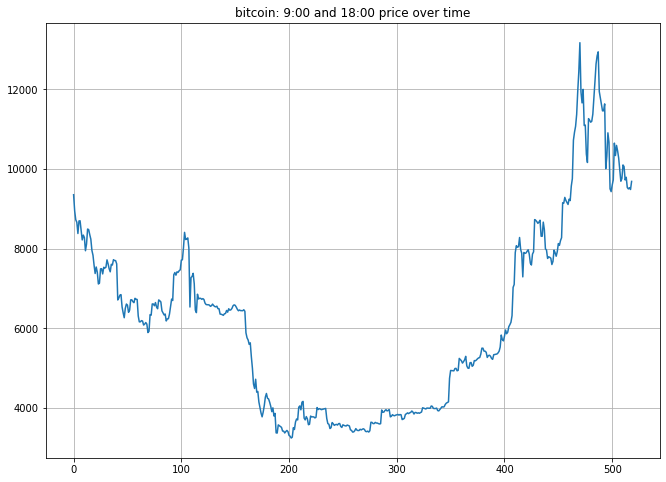

In [14]:
ax = merged['open'].plot(figsize=(11, 8), rot=0)
g = ax.grid(True)
t = ax.title.set_text("bitcoin: 9:00 and 18:00 price over time")

In [15]:
print(merged['Date'].value_counts().head(10))
#check whether the duplicates are all cleaned 

2018/10/17    2
2018/11/01    2
2019/01/16    2
2018/05/21    2
2019/03/06    2
2019/01/09    2
2019/05/06    2
2019/02/06    2
2018/10/22    2
2019/05/15    2
Name: Date, dtype: int64


In [16]:
print(len(merged.Date.unique()),len(merged.date.unique()))
print("The length of the joint table is as expected")


256 256
The length of the joint table is as expected


In [17]:
merged['bitcoin overnight return'] = merged.open.pct_change()
merged = merged[1:].iloc[::2]
final_df = merged[['Date','overnight_ret','amount','bitcoin overnight return']]
final_df.set_index('Date',inplace = True)
final_df


,overnight_ret,amount,bitcoin overnight return
Date,,,
2018/05/11,0.014251,281220.35930,-0.043730
2018/05/14,0.020854,106738.77820,-0.007090
2018/05/15,-0.002753,75746.58923,0.037636
2018/05/16,0.012968,58929.39447,-0.029064
2018/05/17,0.008750,79298.87482,0.014695
...,...,...,...
2019/07/24,-0.004309,90214.57380,0.007129
2019/07/25,-0.000603,62052.03350,-0.004075
2019/07/26,0.012018,185534.05570,0.006874


In [18]:
np.cov(final_df.overnight_ret,final_df['bitcoin overnight return'])

array([[2.88661483e-04, 9.34388843e-06],
       [9.34388843e-06, 7.30724066e-04]])

In [19]:
final_df['Dummy'] = 0
final_df['Dummy'].loc[final_df['bitcoin overnight return'] > 0] = 1
np.cov(final_df.overnight_ret,final_df.Dummy)

/Users/guapofish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/guapofish/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/guapofish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

array([[2.88661483e-04, 9.36191587e-06],
       [9.36191587e-06, 2.49262814e-01]])

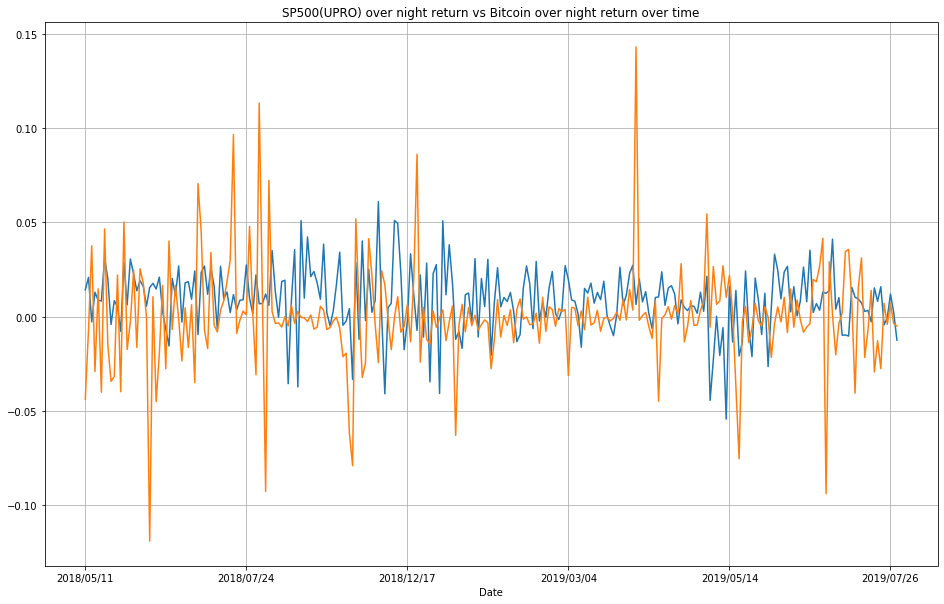

In [20]:
ax = final_df['overnight_ret'].plot(figsize=(16, 10), rot=0)
ax = final_df['bitcoin overnight return'].plot(figsize=(16, 10), rot=0)
g = ax.grid(True)
t = ax.title.set_text("SP500(UPRO) over night return vs Bitcoin over night return over time") 


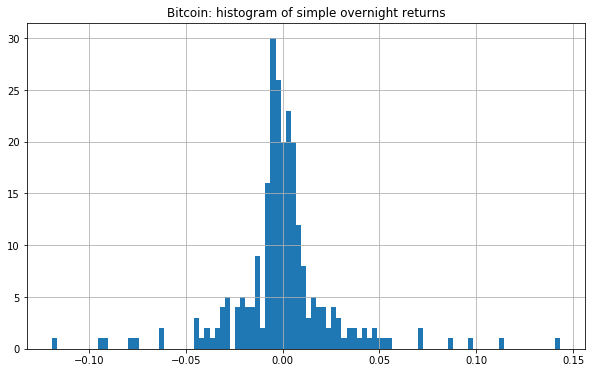

In [21]:
ax = final_df['bitcoin overnight return'].hist(bins=100, figsize=(10, 6))
g = ax.grid(True)
t = ax.title.set_text("Bitcoin: histogram of simple overnight returns")

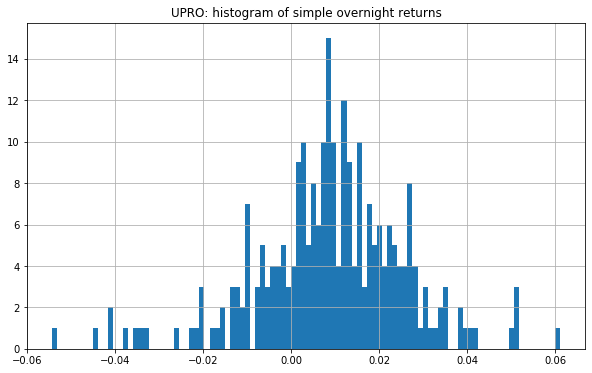

In [22]:
ax = final_df['overnight_ret'].hist(bins=100, figsize=(10, 6))
g = ax.grid(True)
t = ax.title.set_text("UPRO: histogram of simple overnight returns")

# Prediction using SVM


In [23]:
def SVM_pred(final_df):
    
    X = final_df['Dummy']
    y = final_df['overnight_ret']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

    X_train = np.array(X_train.tolist()).reshape(-1,1)
    X_test = np.array(X_test.tolist()).reshape(-1,1)
    y_train = np.array(y_train.tolist())
    y_test = np.array(y_test.tolist())
    #X_train.shape, X_test.shape,y_train.shape, y_test.shape

    svr = SVR(epsilon = 0.1,kernel='rbf')
    svr.fit(X_train, y_train)
    print("In sample R^2 is:" +str(svr.score(X_train, y_train)))
    print("Out of sample R^2 is:" +str(svr.score(X_test, y_test)))

In [24]:
SVM_pred(final_df)

In sample R^2 is:-0.11692850172813496
Out of sample R^2 is:-0.0719170461862757
